<a href="https://colab.research.google.com/github/chandrakanta-chaudhury/Audio_signals_Research/blob/master/U_net_denoise_signals_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.io import wavfile
import scipy.io
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

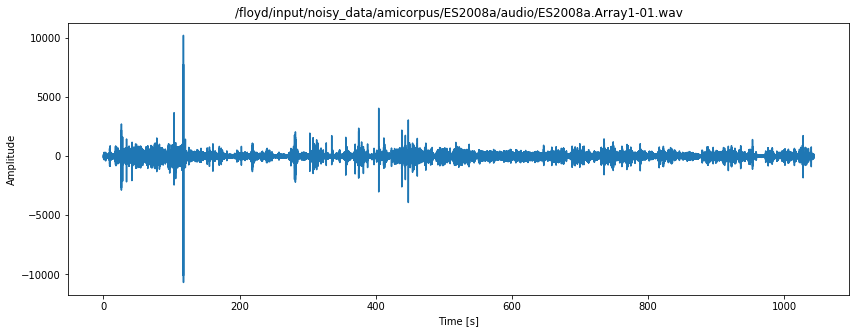

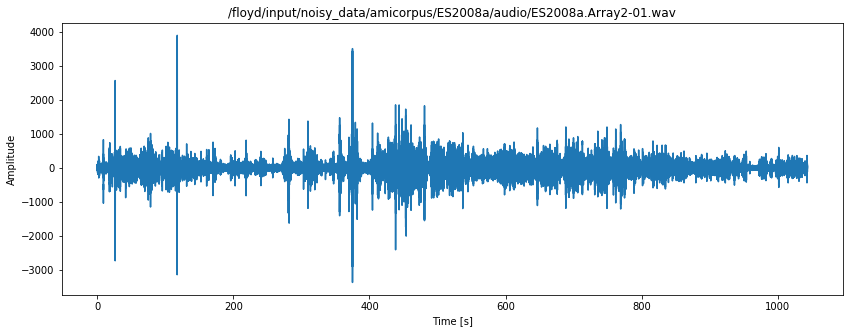

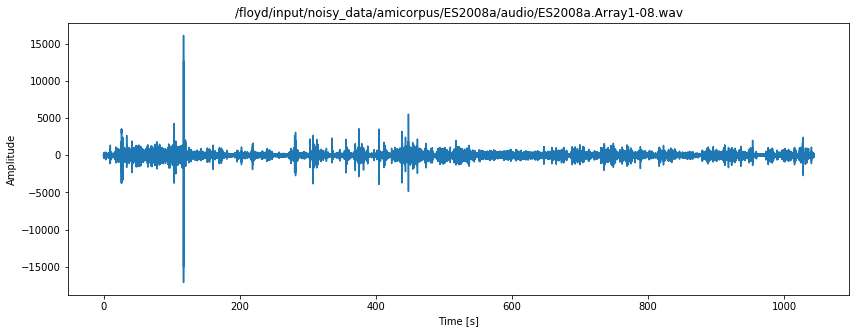

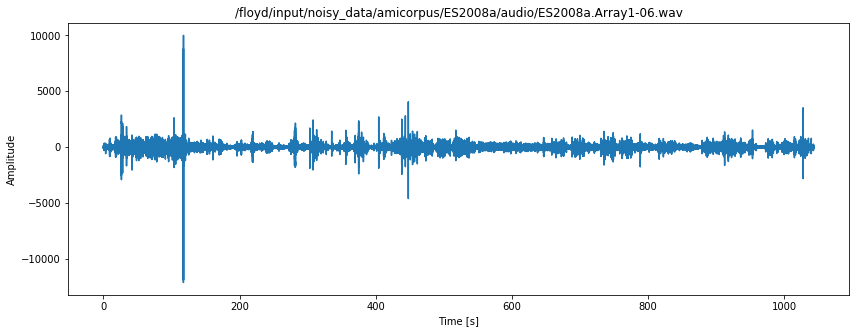

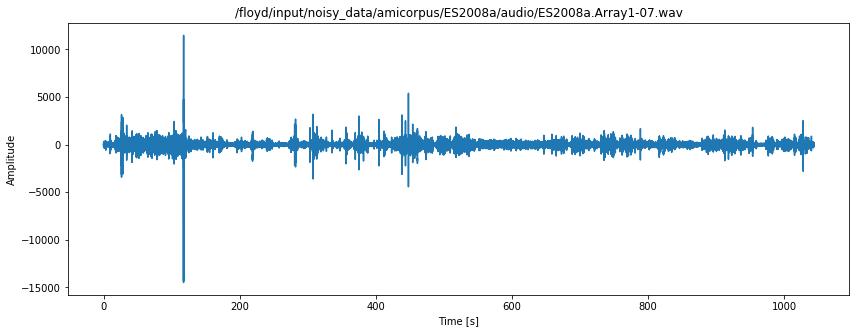

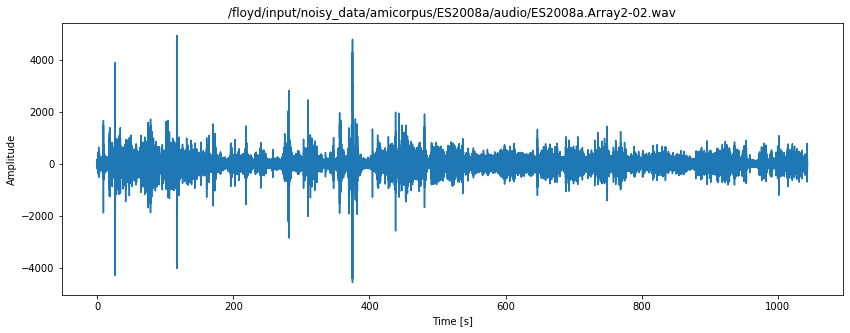

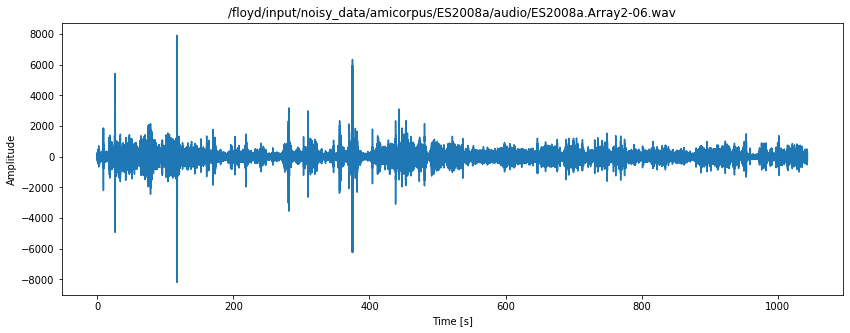

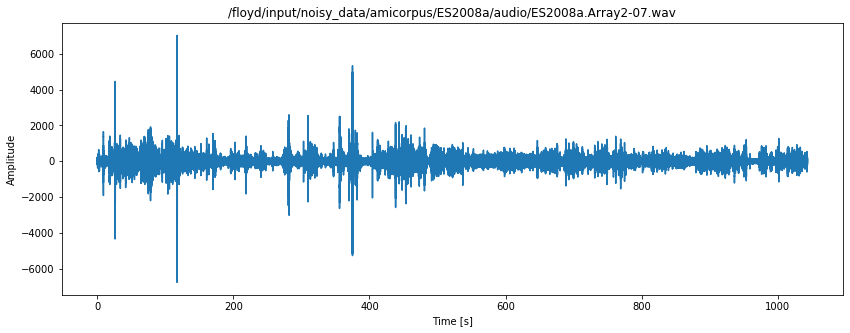

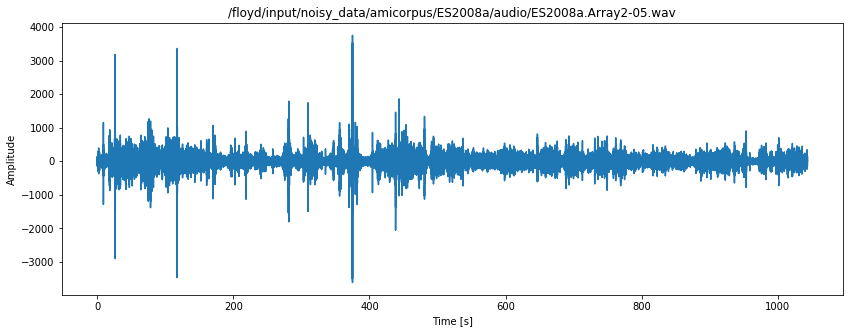

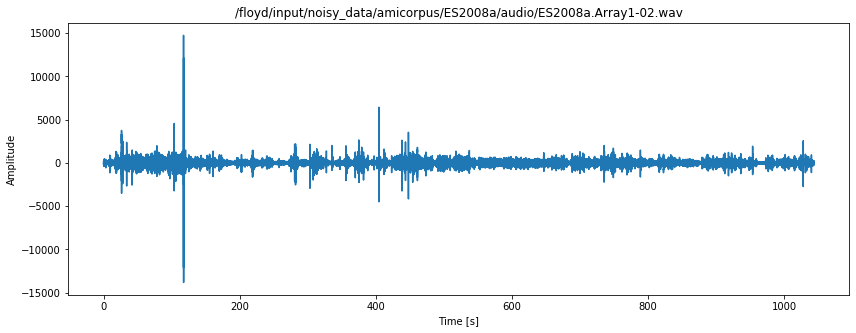

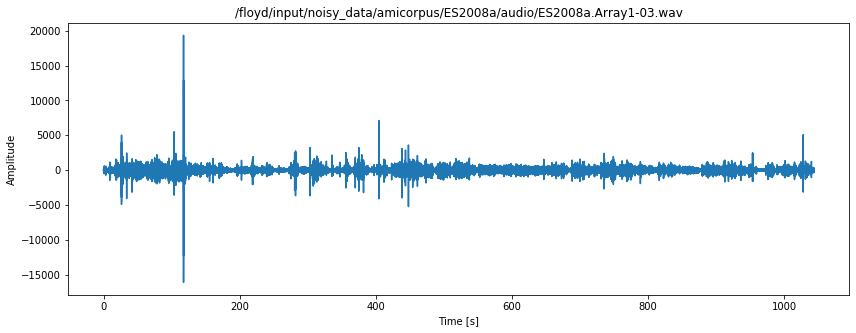

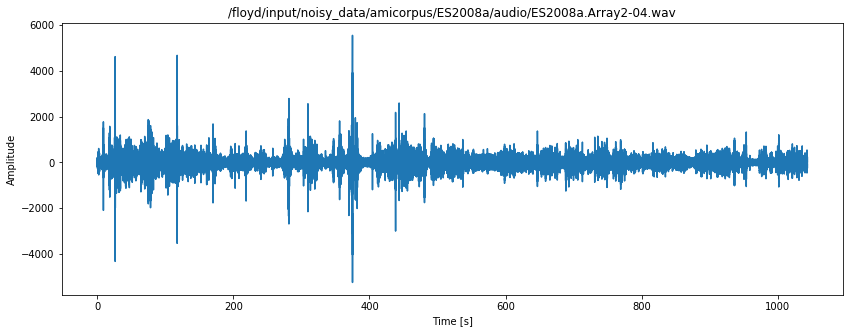

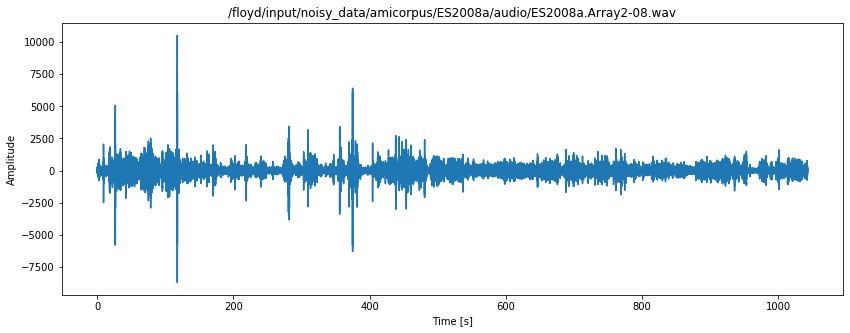

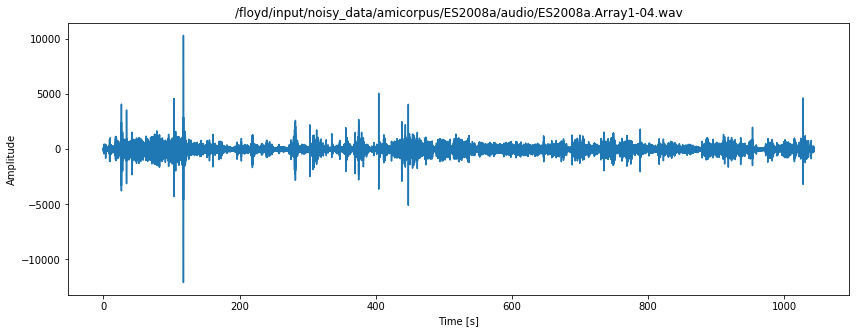

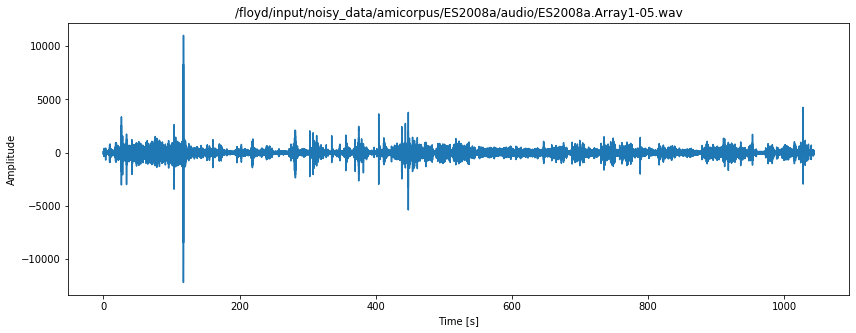

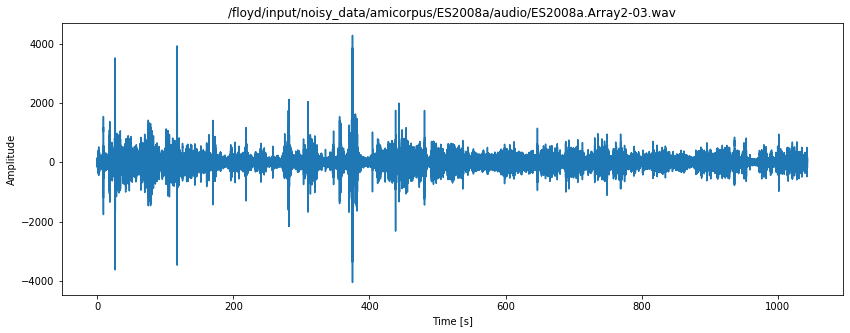

In [ ]:
for fname in glob("/floyd/input/noisy_data/amicorpus/ES2008a/audio/ES*.wav"):
  sr,x = wavfile.read(fname)
  plt.figure(figsize=(14, 5))
  duration = len(x)/sr
  time = np.arange(0,duration,1/sr)
  plt.plot(time,x)
  plt.xlabel('Time [s]')
  plt.ylabel('Amplitude')
  plt.title(fname)
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
X_org = []
pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
for fname in glob("/content/drive/My Drive/amicorpus/ES2008a/audio/ES2008a.Array*.wav"):
  sr,x = wavfile.read(fname)
  padded = pad(x, 16384)
  X_org.append(padded)  

In [ ]:
#Noise signals create
def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/20)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import math
signal=np.interp(x, (x.min(), x.max()), (-1, 1))
noise=get_white_noise(signal,SNR=10)

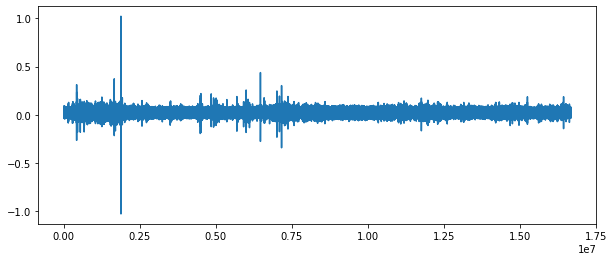

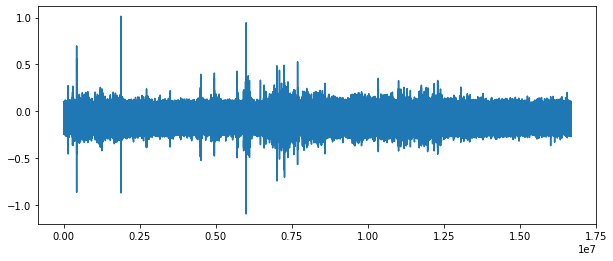

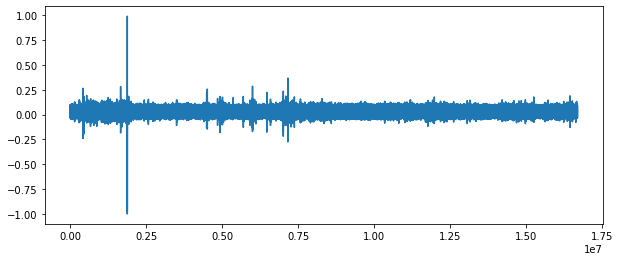

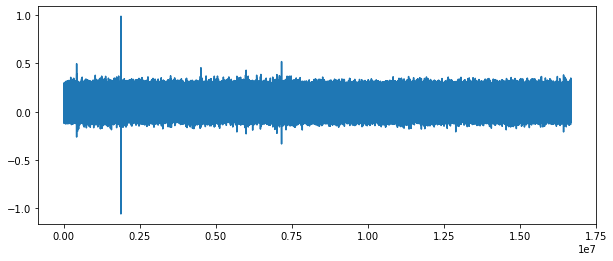

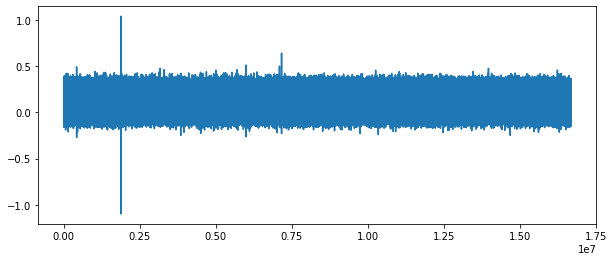

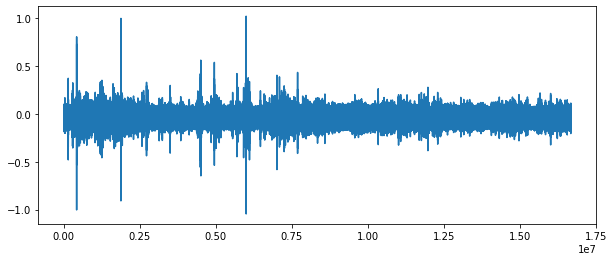

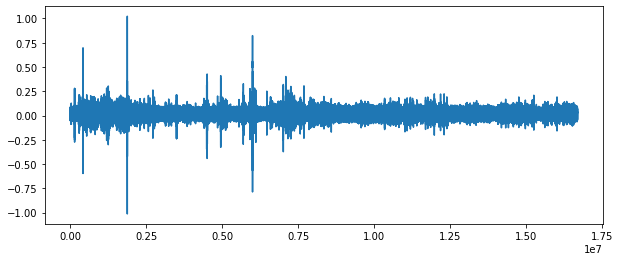

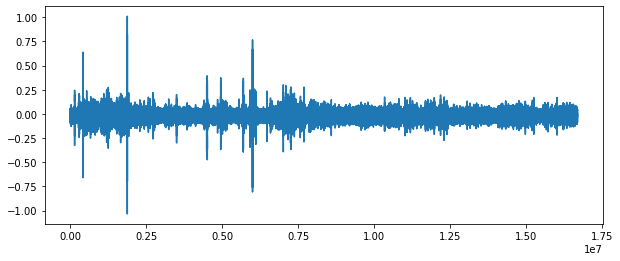

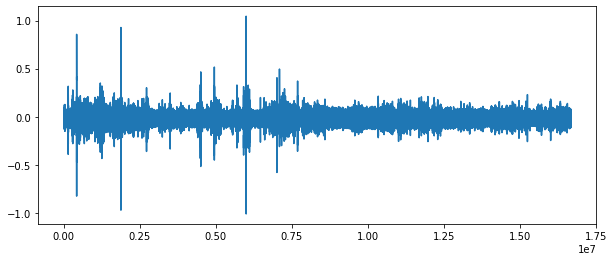

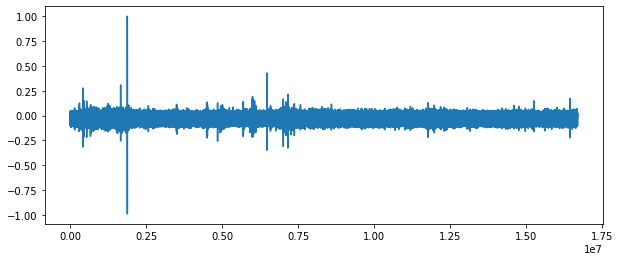

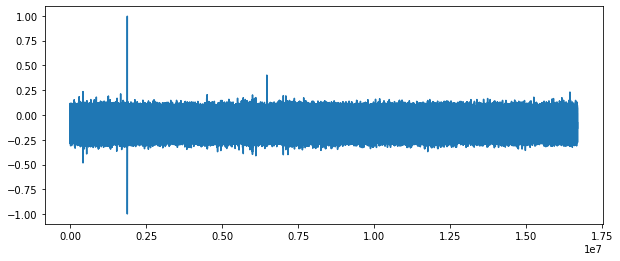

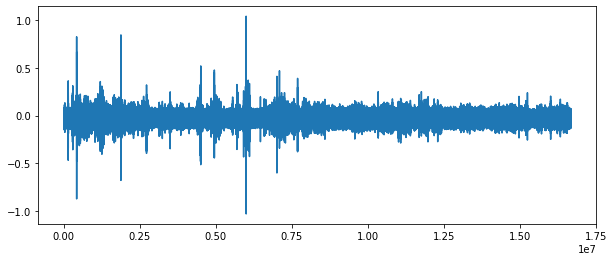

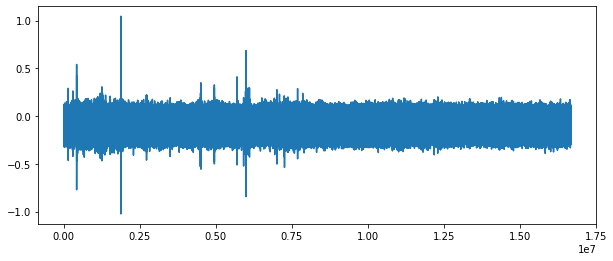

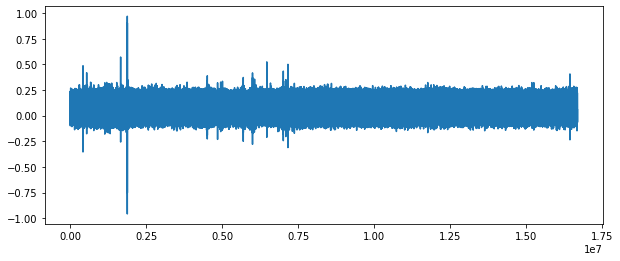

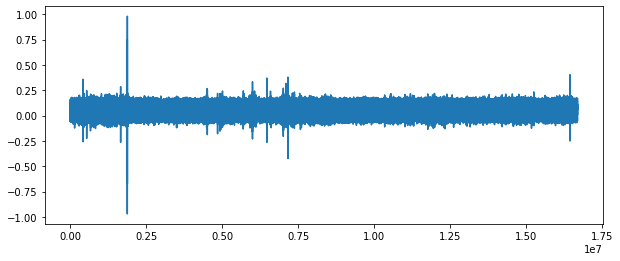

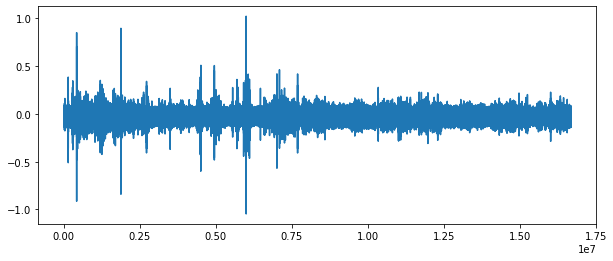

In [ ]:
#After adding noise to audio signals
X = []
pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
import matplotlib.pyplot as plt
for fname in glob("/floyd/input/noisy_data/amicorpus/ES2008a/audio/ES*.wav"):
  sr,x = wavfile.read(fname)
  signal=np.interp(x, (x.min(), x.max()), (-1, 1))
  noise=get_white_noise(signal,SNR=10)
  signal_noise=signal+noise
  padded = pad(signal_noise, 4096)
  X.append(padded)
  fig, ax = plt.subplots(figsize=(10,4))
  ax.plot(signal_noise)
  #plt.plot(signal_noise)

In [ ]:
#dont run this , as i had run it this before u can delete it 
X = []
pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
for fname in glob("/content/drive/My Drive/amicorpus/ES2008a/audio/ES2008a.Array*.wav"):
  sr,x = wavfile.read(fname)
  signal=np.interp(x, (x.min(), x.max()), (-1, 1))
  noise=get_white_noise(signal,SNR=10)
  signal_noise=signal+noise
  padded = pad(signal_noise, 16384)
  X.append(padded)

In [ ]:
X=np.vstack(X)

In [ ]:
X.shape

(8, 16384)

In [ ]:
X_org=np.vstack(X_org)

In [ ]:
X_org.shape

(8, 16384)

In [ ]:
#split into train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X,X_org,test_size=0.2)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(6, 16384) (2, 16384) (6, 16384) (2, 16384)


In [ ]:
#reshape
X_train=X_train.reshape(128,128,6)
y_train=y_train.reshape(128,128,6)
X_test=X_test.reshape(128,128,2)
y_test=y_test.reshape(128,128,2)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf

In [ ]:
##resahping it again to avoid dimensional error
X_train = X_train.reshape(6,128,128,1)
y_train=y_train.reshape(6,128,128,1)
X_test=X_test.reshape(2,128,128,1)
y_test=y_test.reshape(2,128,128,1)

In [ ]:
    input_size = (128,128,1)
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

In [ ]:
 model = Model(inputs,conv10)

In [ ]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])

In [ ]:
model.fit(X_train,y_train,
              epochs=10,
              batch_size=1,
             shuffle=True,
            validation_data=(X_test,y_test))

Epoch 1/10
6/6 [==============================] - 2s 257ms/step - loss: 50.5877 - mae: 51.0846 - val_loss: 51.8037 - val_mae: 52.3005
Epoch 2/10
6/6 [==============================] - 1s 209ms/step - loss: 50.5752 - mae: 51.0720 - val_loss: 51.7973 - val_mae: 52.2937
Epoch 3/10
6/6 [==============================] - 1s 206ms/step - loss: 50.5642 - mae: 51.0608 - val_loss: 51.7765 - val_mae: 52.2731
Epoch 4/10
6/6 [==============================] - 1s 203ms/step - loss: 50.5658 - mae: 51.0625 - val_loss: 51.8389 - val_mae: 52.3357
Epoch 5/10
6/6 [==============================] - 1s 205ms/step - loss: 50.5479 - mae: 51.0443 - val_loss: 51.7992 - val_mae: 52.2955
Epoch 6/10
6/6 [==============================] - 1s 205ms/step - loss: 50.5690 - mae: 51.0657 - val_loss: 51.7997 - val_mae: 52.2962
Epoch 7/10
6/6 [==============================] - 1s 205ms/step - loss: 50.5680 - mae: 51.0647 - val_loss: 51.8007 - val_mae: 52.2971
Epoch 8/10
6/6 [==============================] - 1s 206ms/ste

In [ ]:
y=model.predict(X_test)

In [ ]:
y.shape

(2, 128, 128, 1)

In [ ]:
y=y.reshape(16384,2)

In [ ]:
y2=y[:,0]

In [ ]:
y2.shape

(16384,)

In [ ]:
from scipy.io.wavfile import write
write("test01.wav", sr, y2)

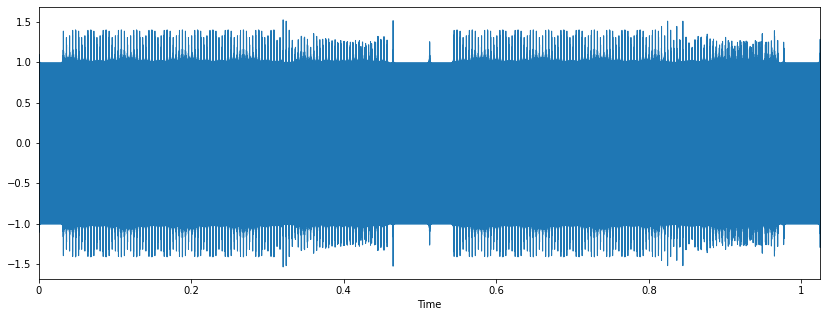

In [3]:
import librosa
import matplotlib.pyplot as plt
fname="/content/test01.wav"
x , sr = librosa.load(fname)
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x,sr=sr)